In [1]:
from helper import *
from data import *
from models import *

%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False 

pd.set_option('display.max_rows', 100)    
pd.set_option('display.max_colwidth', 100)    

%load_ext autoreload
%autoreload 2

data_path = os.getcwd() + "/data"

In [2]:
f = os.path.join(data_path, "kb.csv")
if os.path.exists(f):
    kb_question = pd.read_csv(f)
else:
    kb_question = read_kb(data_path)
    kb_question.to_csv('kb_question.csv', index=False, encoding='utf-8-sig')

original shape:  (35386, 3)
dropping duplicates ...
after dropping duplicates:  (34121, 3)


In [3]:
train, dev, test = np.split(kb_question.sample(frac=1), [int(.8*len(kb_question)), int(.9*len(kb_question))])

if not os.path.exists('train.csv'):
    train_df = create_pair_data(train)
    train_df.to_csv("train.csv", index=False, header=False, encoding='utf_8_sig')
else:
    train_df = pd.read_csv('train.csv', header=None)
    
if not os.path.exists('dev.csv'):
    dev_df = create_pair_data(dev)
    dev_df.to_csv("dev.csv", index=False, header=False, encoding='utf_8_sig')
else:
    dev_df = pd.read_csv('dev.csv', header=None)
    
if not os.path.exists('test.csv'):
    test_df = create_pair_data(test)
    test_df.to_csv("test.csv", index=False, header=False, encoding='utf_8_sig')
else:
    test_df = pd.read_csv('test.csv', header=None)

In [4]:
print(train_df.shape)
train_df = train_df.drop_duplicates()
print(train_df.shape)

(1082702, 3)
(1082702, 3)


In [5]:
# display(train_df.head(15))

In [6]:
train, dev, test = get_nl("")

processing train.csv ...
** TRAIN DATA : Found 1082702 pairs of train sentences.
processing dev.csv ...
** DEV DATA : Found 122620 pairs of dev sentences.
processing test.csv ...
** TEST DATA : Found 122692 pairs of test sentences.


In [7]:
wv, default_wv = build_vocab(np.append(train['s1'], train['s2']), "w2v-model.txt")

Found 5312(/6292) words with w2v vectors
vocab size: 6292


In [8]:
config_nli_model = {
    'n_words'        :  len(wv),
    'word_emb_dim'   :  300,
    'enc_lstm_dim'   :  512,
    'n_enc_layers'   :  1,
    'dpout_model'    :  0,
    'dpout_fc'       :  0.3,
    'fc_dim'         :  256,
    'bsize'          :  64,
    'n_classes'      :  1,
    'pool_type'      :  'max',
    'encoder_type'   :  'GRUEncoder',
    'use_cuda'       :  False,
}

In [9]:
torch.cuda.set_device(0)
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [10]:
from models import *
nli_net = NLINet(config_nli_model)
print(nli_net)

NLINet(
  (encoder): GRUEncoder(
    (enc_lstm): GRU(300, 512)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.3)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): Tanh()
    (3): Dropout(p=0.3)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [11]:
# nli_net.load_state_dict(torch.load(os.path.join("saved_model", "model_1")))

In [12]:
# loss 
weight = torch.FloatTensor(3).fill_(1)
loss_fn = nn.CrossEntropyLoss(weight=weight)
loss_fn.size_average = False


# optimizer
from torch import optim
optimizer = optim.Adam(nli_net.parameters(), lr=0.0001)

In [13]:
nli_net.cuda()
loss_fn.cuda()

CrossEntropyLoss()

In [14]:
def trainepoch(epoch, bsize = 64):
    all_costs = []
    tot_costs = []
    logs = []
    correct = 0.0
    
    nli_net.train()
    permutation = np.random.permutation(len(train['s1']))
    s1 = train['s1'][permutation]
    s2 = train['s2'][permutation]
    target = train['label'][permutation]
    
    for stidx in range(0, len(s1), bsize):
        s1_batch, s1_len = get_batch(s1[stidx:stidx+bsize], wv, default_wv)
        s2_batch, s2_len = get_batch(s2[stidx:stidx+bsize], wv, default_wv)

        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[stidx:stidx + bsize])).cuda()
        k = s1_batch.size(1)
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))

        pred = output.data.max(1)[1]
        correct += pred.long().eq(tgt_batch.data.long()).cpu().sum().item()

        # loss
        loss = loss_fn(output, tgt_batch)
        all_costs.append(loss.item())
        tot_costs.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if len(all_costs) == 100:
            logs.append('{0} ; loss {1}  ; accuracy train : {2}'.format(stidx, 
                            round(np.mean(all_costs), 2), round(100.*correct/(stidx+k), 2)))
            print(logs[-1])
            all_costs = []
            
    train_acc = round(100 * correct/len(s1), 2)
    train_loss = round(np.mean(tot_costs), 2)
    return train_loss, train_acc    

In [15]:
val_acc_best = -1e10
adam_stop = False
stop_training = False

def evaluate(epoch, bsize = 64, eval_type='dev', final_eval=False):
    nli_net.eval()
    correct = 0.0
    global val_acc_best, lr, stop_training, adam_stop
    
    s1 = dev['s1'] if eval_type == 'dev' else test['s1']
    s2 = dev['s2'] if eval_type == 'dev' else test['s2']
    target = dev['label'] if eval_type == 'dev' else test['label']

    for i in range(0, len(s1), bsize):
        # prepare batch
        s1_batch, s1_len = get_batch(s1[i:i + bsize], wv, default_wv)
        s2_batch, s2_len = get_batch(s2[i:i + bsize], wv, default_wv)
        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[i:i + bsize])).cuda()

        # model forward
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))

        pred = output.data.max(1)[1]
        correct += pred.long().eq(tgt_batch.data.long()).cpu().sum().item()

    # save model
    eval_acc = round(100 * correct / len(s1), 2)
    if final_eval:
        print('finalgrep : accuracy {0} : {1}'.format(eval_type, eval_acc))
    else:
        print('togrep : results : epoch {0} ; mean accuracy {1} :{2}'.format(epoch, eval_type, eval_acc))

    if eval_type == 'dev' and eval_acc > val_acc_best:
        print('saving model at epoch {0}'.format(epoch))
        if not os.path.exists("saved_model"): os.makedirs("saved_model")
        torch.save(nli_net.state_dict(), os.path.join("saved_model", "model_1"))
        val_acc_best = eval_acc

    return eval_acc

In [ ]:
### TRAINING 

train_loss_ls = []
train_acc_ls = []
eval_acc_ls = []
for i in range(100):
    print('\nTRAINING : Epoch ' + str(i))
    train_loss, train_acc = trainepoch(i)
    train_loss_ls.append(train_loss)
    train_acc_ls.append(train_acc)
    print('results : epoch {0} ; loss: {1} mean accuracy train : {2}'.format(i, train_loss, train_acc))
    if i%1==0:
        print("-"*100)
        print('\nEVALIDATING : Epoch ' + str(i))
        eval_acc = evaluate(i, bsize = 64, eval_type='dev', final_eval=False)
        eval_acc_ls.append(eval_acc)
        print('results : epoch {0} ;  mean accuracy dev : {1}'.format(i, eval_acc))
        print("-"*100)


TRAINING : Epoch 0
6336 ; loss 1.03  ; accuracy train : 51.06
12736 ; loss 1.0  ; accuracy train : 52.46
19136 ; loss 0.92  ; accuracy train : 53.63
25536 ; loss 0.89  ; accuracy train : 54.45
31936 ; loss 0.84  ; accuracy train : 55.61
38336 ; loss 0.81  ; accuracy train : 56.62
44736 ; loss 0.79  ; accuracy train : 57.48
51136 ; loss 0.79  ; accuracy train : 58.03
57536 ; loss 0.78  ; accuracy train : 58.59
63936 ; loss 0.76  ; accuracy train : 59.08
70336 ; loss 0.76  ; accuracy train : 59.59
76736 ; loss 0.75  ; accuracy train : 59.94
83136 ; loss 0.75  ; accuracy train : 60.24
89536 ; loss 0.74  ; accuracy train : 60.52
95936 ; loss 0.73  ; accuracy train : 60.8
102336 ; loss 0.73  ; accuracy train : 61.08
108736 ; loss 0.72  ; accuracy train : 61.35
115136 ; loss 0.71  ; accuracy train : 61.62
121536 ; loss 0.71  ; accuracy train : 61.86
127936 ; loss 0.7  ; accuracy train : 62.08
134336 ; loss 0.7  ; accuracy train : 62.28
140736 ; loss 0.7  ; accuracy train : 62.5
147136 ; los

115136 ; loss 0.48  ; accuracy train : 76.56
121536 ; loss 0.48  ; accuracy train : 76.58
127936 ; loss 0.47  ; accuracy train : 76.59
134336 ; loss 0.48  ; accuracy train : 76.58
140736 ; loss 0.47  ; accuracy train : 76.59
147136 ; loss 0.47  ; accuracy train : 76.59
153536 ; loss 0.47  ; accuracy train : 76.61
159936 ; loss 0.48  ; accuracy train : 76.63
166336 ; loss 0.47  ; accuracy train : 76.67
172736 ; loss 0.47  ; accuracy train : 76.7
179136 ; loss 0.46  ; accuracy train : 76.69
185536 ; loss 0.47  ; accuracy train : 76.68
191936 ; loss 0.46  ; accuracy train : 76.69
198336 ; loss 0.47  ; accuracy train : 76.72
204736 ; loss 0.46  ; accuracy train : 76.73
211136 ; loss 0.48  ; accuracy train : 76.72
217536 ; loss 0.46  ; accuracy train : 76.75
223936 ; loss 0.46  ; accuracy train : 76.77
230336 ; loss 0.46  ; accuracy train : 76.78
236736 ; loss 0.46  ; accuracy train : 76.78
243136 ; loss 0.46  ; accuracy train : 76.8
249536 ; loss 0.47  ; accuracy train : 76.82
255936 ; los

223936 ; loss 0.38  ; accuracy train : 80.32
230336 ; loss 0.39  ; accuracy train : 80.33
236736 ; loss 0.39  ; accuracy train : 80.33
243136 ; loss 0.4  ; accuracy train : 80.33
249536 ; loss 0.38  ; accuracy train : 80.31
255936 ; loss 0.38  ; accuracy train : 80.34
262336 ; loss 0.38  ; accuracy train : 80.36
268736 ; loss 0.39  ; accuracy train : 80.36
275136 ; loss 0.38  ; accuracy train : 80.38
281536 ; loss 0.4  ; accuracy train : 80.38
287936 ; loss 0.38  ; accuracy train : 80.39
294336 ; loss 0.39  ; accuracy train : 80.38
300736 ; loss 0.38  ; accuracy train : 80.39
307136 ; loss 0.39  ; accuracy train : 80.39
313536 ; loss 0.4  ; accuracy train : 80.38
319936 ; loss 0.39  ; accuracy train : 80.39
326336 ; loss 0.39  ; accuracy train : 80.39
332736 ; loss 0.39  ; accuracy train : 80.39
339136 ; loss 0.38  ; accuracy train : 80.41
345536 ; loss 0.39  ; accuracy train : 80.41
351936 ; loss 0.38  ; accuracy train : 80.4
358336 ; loss 0.38  ; accuracy train : 80.4
364736 ; loss 0

332736 ; loss 0.35  ; accuracy train : 82.28
339136 ; loss 0.35  ; accuracy train : 82.27
345536 ; loss 0.35  ; accuracy train : 82.27
351936 ; loss 0.36  ; accuracy train : 82.24
358336 ; loss 0.34  ; accuracy train : 82.25
364736 ; loss 0.35  ; accuracy train : 82.25
371136 ; loss 0.34  ; accuracy train : 82.26
377536 ; loss 0.35  ; accuracy train : 82.25
383936 ; loss 0.35  ; accuracy train : 82.26
390336 ; loss 0.35  ; accuracy train : 82.25
396736 ; loss 0.35  ; accuracy train : 82.26
403136 ; loss 0.35  ; accuracy train : 82.25
409536 ; loss 0.35  ; accuracy train : 82.25
415936 ; loss 0.34  ; accuracy train : 82.25
422336 ; loss 0.35  ; accuracy train : 82.25
428736 ; loss 0.35  ; accuracy train : 82.25
435136 ; loss 0.34  ; accuracy train : 82.25
441536 ; loss 0.35  ; accuracy train : 82.26
447936 ; loss 0.36  ; accuracy train : 82.26
454336 ; loss 0.36  ; accuracy train : 82.26
460736 ; loss 0.35  ; accuracy train : 82.25
467136 ; loss 0.34  ; accuracy train : 82.26
473536 ; l

441536 ; loss 0.33  ; accuracy train : 83.45
447936 ; loss 0.33  ; accuracy train : 83.45
454336 ; loss 0.33  ; accuracy train : 83.45
460736 ; loss 0.32  ; accuracy train : 83.45
467136 ; loss 0.32  ; accuracy train : 83.45
473536 ; loss 0.32  ; accuracy train : 83.46
results : epoch 8 ; loss: 0.32 mean accuracy train : 83.45
----------------------------------------------------------------------------------------------------

EVALIDATING : Epoch 8
togrep : results : epoch 8 ; mean accuracy dev :76.91
results : epoch 8 ;  mean accuracy dev : 76.91
----------------------------------------------------------------------------------------------------

TRAINING : Epoch 9
6336 ; loss 0.31  ; accuracy train : 84.19
12736 ; loss 0.31  ; accuracy train : 84.03
19136 ; loss 0.3  ; accuracy train : 84.1
25536 ; loss 0.32  ; accuracy train : 84.04
31936 ; loss 0.3  ; accuracy train : 84.17
38336 ; loss 0.32  ; accuracy train : 84.13
44736 ; loss 0.3  ; accuracy train : 84.22
51136 ; loss 0.3  ; ac

In [ ]:
train.shape

In [22]:
### LOAD MODEL, TEST
nli_net.load_state_dict(torch.load(os.path.join("saved_model", "model_1")))

In [55]:
def test_onePair(s1, s2):
    nli_net.eval()
    
    s1_batch, s1_len = get_batch(s1, wv, default_wv)
    s2_batch, s2_len = get_batch(s2, wv, default_wv)
    s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())

    # model forward
    output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
    pred = output.data.max(1)[1]
    return pred.item()

In [56]:
# test_vec1 = ["苏宁 易 购 所 出售 的 商品 均 为 正品 行货 均 来自 正规 渠道 带 正规 机 打 发票 享受 国家 三 包 服务 质量 和 售后 服务 与 门店 完全 相同 请您 放心 选购"]
# test_vec2 = [ "苏宁 易 购 所 出售 的 商品 均 为 正品 行货 请您 放心 选购"]
# test_vec3 = ["有 统一 的 全 国 售后 服务 正品 质量 保证"]
# test_vec4 = ["所有 货物 都 是 正品 请 安心 购买"]
# test_vec5 = ["正规 发票 服务 完全 相同 放心 享受 服务"]

In [84]:
# ind = 30
# s1 = test['s1'][ind]
# s2 = test['s2'][ind]
# label = test['label'][ind]
# print(s1)
# print(s2)
# print(label)
s1 = "空调 昨天 已 送 到 了，什么 时候 来 安装 啊"
s2 = "什么时候 上门 安装"
print(test_onePair([s1], [s2]))

2


In [14]:
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
# wv = KeyedVectors.load_word2vec_format("allQuestions.model.bin", binary=True)

In [16]:
# vector_dim = 300
# embedding_matrix = np.zeros((len(wv.vocab), vector_dim))
# avg = np.zeros((1, vector_dim))
# for i in range(len(wv.vocab)):
#     embedding_vector = wv[wv.index2word[i]]
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector
#         avg += embedding_vector
# avg /= len(wv.vocab)

## EDA

In [7]:
kb_answer = pd.read_csv(data_path+'/kb.csv').dropna(axis=1)
ha_answer = pd.read_csv(data_path+'/qa_history.csv').dropna(subset=['参考答案分词', '坐席回复分词', '坐席回复'], how='any')

In [8]:
kb_answer['答案长度'] = kb_answer['默认答案'].apply(lambda x: len(x))
kb_answer['分词长度'] = kb_answer['答案分词'].apply(lambda x: len(x.split()))
ha_answer['参考答案长度'] = ha_answer['参考答案'].apply(lambda x: len(x))
ha_answer['参考答案分词长度'] = ha_answer['参考答案分词'].apply(lambda x: len(x.split()))
ha_answer['坐席回复长度'] = ha_answer['坐席回复'].apply(lambda x: len(x))
ha_answer['坐席回复分词长度'] = ha_answer['坐席回复分词'].apply(lambda x: len(x.split()))

In [5]:
display(ha_answer.sample(n=100).iloc[:, :4])

,用户问题,参考答案,坐席回复,回复类型
23026,谢谢,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,不客气，亲爱哒，很高兴为您服务。,编辑后采用
2816,就是苏宁支付我密码不对,电脑端可直接https://pay.suning.com/epp-epw/security/security-manage!initSecurityCenter.action点击这里重置支付密...,电脑端可直接https://pay.suning.com/epp-epw/security/security-manage!initSecurityCenter.action点击这里重置支付密...,编辑后采用
1314,这个奶粉日期是什么时候的,由于进货批次不同生产地点不同，生产日期具体可以在包装上查询，不过您放心我司所售产品均在保质期内，部分临期的商品会在页面做临期提示，请您放心购买哦！收货时如果您对保质期不满意，可以选择拒收！,由于进货批次不同生产地点不同，生产日期具体可以在包装上查询，不过您放心我司所售产品均在保质期内，部分临期的商品会在页面做临期提示，请您放心购买哦！收货时如果您对保质期不满意，可以选择拒收！,编辑后采用
3542,节能补贴在哪里上传图片,补贴流程 1、在苏宁易购选购节能减排补贴商品，并支付(仅限北京地区)； 2、支付后一小时内，需上传身份证件扫描件(仅限北京户口)； 3、苏宁代消费者将相关身份证件信息提交至政府系统进行审核，如...,补贴流程 1、在苏宁易购选购节能减排补贴商品，并支付(仅限北京地区)； 2、支付后一小时内，需上传身份证件扫描件(仅限北京户口)； 3、苏宁代消费者将相关身份证件信息提交至政府系统进行审核，如...,编辑后采用
10929,没关系，,好的，您真是宽容大度呢！,您真是宽容大度呢！,编辑后采用
92,上门维修有统一价格么,保内/延保期内维修：机器本身故障问题，免费维修；保外维修/人为原因导致机器故障：收费维修。实际收费标准需工程师上门判断故障类型后再确定。可以$url=http://help.suning.co...,保内/延保期内维修：机器本身故障问题，免费维修；保外维修/人为原因导致机器故障：收费维修。实际收费标准需工程师上门判断故障类型后再确定。可以$url=http://help.suning.co...,编辑后采用
8819,谢谢,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,编辑后采用
15530,没有了，谢谢,不客气，亲爱的，应该的哈！,不客气 不客气，亲爱的，应该的哈！,编辑后采用
13752,谢谢,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,编辑后采用
23048,那空调安装费呢,苏宁安装新机安装免人工费，工程师服务前向用户出示收费价目表/明细，并提前做好预算取得顾客同意，收费不得高于页面标准http://help.suning.com/page/id-478.htm，...,苏宁安装新机安装免人工费，工程师服务前向用户出示收费价目表/明细，并提前做好预算取得顾客同意，收费不得高于页面标准http://help.suning.com/page/id-478.htm，...,编辑后采用


In [442]:
display(ha_answer.describe())

,参考答案长度,参考答案分词长度,坐席回复长度,坐席回复分词长度
count,23845.000000,23845.000000,23845.000000,23845.000000
mean,75.444873,34.646635,50.279975,23.350681
std,58.774332,21.675212,53.794340,21.093126
min,3.000000,1.000000,1.000000,1.000000
25%,46.000000,26.000000,15.000000,7.000000
50%,46.000000,26.000000,28.000000,15.000000
75%,99.000000,49.000000,64.000000,32.000000
max,593.000000,310.000000,449.000000,244.000000


In [562]:
# display(kb_answer.sample(n=100))

In [444]:
# display(kb_answer.describe())

In [445]:
ha_answer_99 = ha_answer[ (ha_answer['参考答案分词长度']<100) & (ha_answer['坐席回复分词长度']<100)]

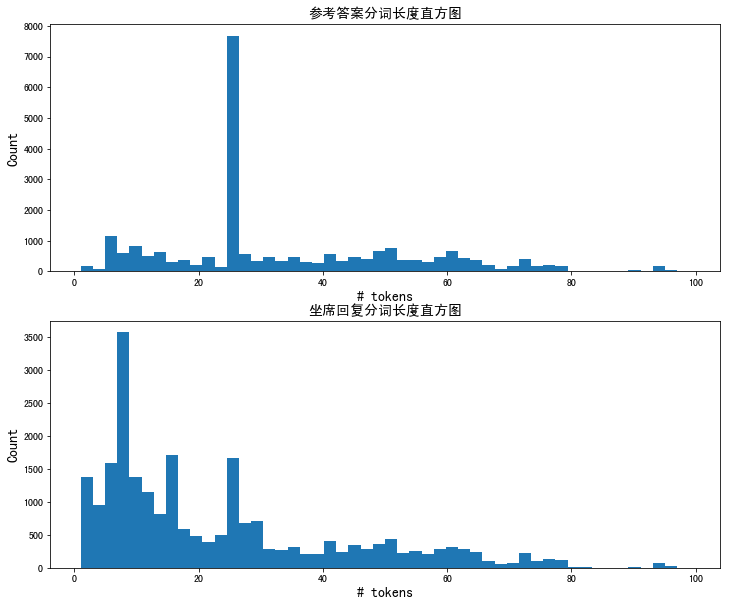

In [446]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.title('参考答案分词长度直方图', fontsize=14)
ax1 = ha_answer_99['参考答案分词长度'].plot(kind='hist', bins=50)
plt.xlabel('# tokens', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.subplot(2,1,2)
plt.title('坐席回复分词长度直方图', fontsize=14)
ax2 = ha_answer_99['坐席回复分词长度'].plot(kind='hist', bins=50)
plt.xlabel("# tokens", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

编辑后采用的答案长度明显比标准答案短

In [451]:
ha_answer_99['diff'] = ha_answer_99.loc[:,'参考答案分词长度']-ha_answer_99.loc[:,'坐席回复分词长度']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


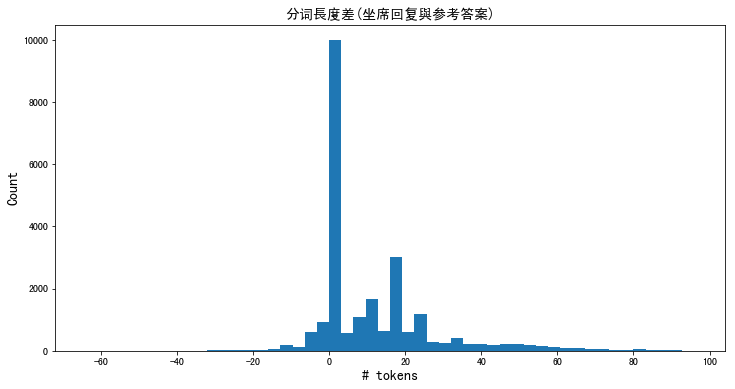

In [452]:
plt.figure(figsize=(12,6))
plt.title("分词長度差(坐席回复與参考答案)", fontsize=14)
ax1 = ha_answer_99['diff'].plot(kind='hist', bins=50)
plt.xlabel("# tokens", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

In [582]:
ha_answer_diff20 = ha_answer_99[ (ha_answer_99['diff']>15) ][['用户问题', '参考答案', '坐席回复', '参考答案分词', '坐席回复分词']]

In [583]:
import re
pattern = re.compile('.*(谢谢)+.*')
def remove_thanks(x):
    res = pattern.search(x)
    return x if not res else None
temp = ha_answer_diff20['用户问题'].apply(lambda x: remove_thanks(x))
ha_answer_diff20 = ha_answer_diff20[~temp.isnull()]

In [584]:
display(ha_answer_diff20[['用户问题', '参考答案', '坐席回复']])

,用户问题,参考答案,坐席回复
3,有质保吗,您好， 因商品生产批次较多，因商品生产批次较多，暂无法确定您购买商品的生产日期，不过请您放心，苏宁所卖商品均按照国家要求的保质期管理规范进行操作的。,亲 有的
4,货到付款的订单能不能修改成在线支付？,下单的时候保存详细的收货地址，在支付方式里面会显示是否支持货到付款的，如果不支持的话会提示您使用在线支付。选择货到付款的支付方式，您可以选择现金支付或者移动POS刷卡支付。点击链接http:/...,欠款-物流收 李小姐 15915717838 广州市南沙区全区南沙街珠电路中央郡5栋1003房
8,空调到了不满意可以无条件退货的吧,1.自实际收货日期的次日起7天内退货（部分已激活商品不支持无理由退），有质量问题15天内可换货，https://assss.suning.com/assss-web/wap/servicefu...,1.自实际收货日期的次日起7天内退货（部分已激活商品不支持无理由退），有质量问题15天内可换货，https://assss.suning.com/assss-web/wap/servicefu...
18,好吧,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,亲，对给您带来的困扰表示抱歉
20,我还是抢不到,网站不提供价格、库存保护，因工厂调价、促销结束、抢购等造成的价格、库存变化以付款时为准。给您造成不便，敬请谅解！,稍等的哈
21,我在苏宁总部，明天可以送到吗？,【苏宁发货】商品，页面会显示预计到达时间（以提交订单时显示的时间为准）下单后按照您指定的日期配送。非苏宁发货商品下单后在48小时内发货，以快递信息为准。http://order.suning....,可以的亲
31,为什么我没有看到有免运费的选项啊,1.自实际收货日期的次日起7天内退货（部分已激活商品不支持无理由退），有质量问题15天内可换货，https://assss.suning.com/assss-web/wap/servicefu...,是的哈亲 上门取件免运费的呢
33,你们是不是还支持7天无理由退货？,页面标注的符合7天无理由退货，商品完好的情况下可办理，具体可点击$url=https://assss.suning.com/assss-web/wap/servicefusion/goRetu...,很高兴为您服务，请问还有其他问题可以帮到您的吗？
40,我买了2副Beats的蓝牙耳机了,煲耳机刚开始用轻柔一些的音乐，在较低音量下让耳机先舒缓10-30小时，然后用普通的音乐(摇滚、舞曲除外)在中等音量状态煲100-200小时。这时你听着高音不刺耳了，变得圆润自然，中音温暖亲切，...,好的呢
46,买别的就可以,待支付的订单若需要修改支付方式，电脑端点击https://order.suning.com/order/orderList.do?transStatus=waitPay 手机端点击我的易购-待...,因产品服务升级，当前该业务暂停服务，开启时间待定，建议多多关注页面。给您带来不便，敬请谅解


- 参考答案 编辑后回覆 比较    
     

"不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。"  
"不客气，亲爱哒"   

"苏宁易购所出售的商品均为正品行货，均来自正规渠道，带正规机打发票，享受国家三包服务，质量和售后服务与门店完全相同，请您放心选购。"   
"苏宁易购所出售的商品均为正品行货，请您放心选购。"   

"【苏宁发货】商品会根据您收货地址自动选择就近的仓库发货。非苏宁发货商品在购买页或物流信息查询里会显示发货地"   
"【苏宁发货】商品会根据您收货地址自动选择就近的仓库发货"    

"【苏宁发货】商品，下单填写地址时能正常保存的就是在配送范围内的，且支持送货上门服务；非苏宁发货商品，建议联系页面上的在线客服确定配送范围哟"   
"【苏宁发货】商品，下单填写地址时能正常保存的就是在配送范围内的，且支持送货上门服务"       

"苏宁易购与天猫苏宁官方旗舰店只是销售平台不同，但均为苏宁销售并发货，有统一的全国售后服务，正品质量保证~"   
"有统一的全国售后服务，正品质量保证"      


"自提、配送都是从中心仓发货的，时间上相差不大。在物流信息中会告知预计到货时间，到货之后会第一时间通知您。请以实际收货时间为准。（温馨提示：送货方式在订单提交后不支持修改）"    
"自提、配送都是从中心仓发货的，时间上相差不大。自提是发到门店您去提货 配送是送货上门的"   

参考答案囊括太多资讯, 回答用户特定问题时只需要其中一部分, 可以看到编辑后的答案通常是撷取一部分的标准答案
如果要对客服答案做评分, 以标准答案为基准做相似度比较可能不是很合适

word level  
1. Jaccard
2. TF-IDF
3. word embedding avg
4. IDF word embedding avg / weighted word embedding avg

Sentence level   
6. sentence embedding - quick thought

## TF-IDF + Cosine Simalarity

In [191]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import pickle

In [217]:
count_vect = CountVectorizer(decode_error="ignore")
x = count_vect.fit_transform( pd.concat([ ha_answer_99['参考答案分词'], ha_answer_99['坐席回复'] ]) )
pickle.dump(count_vect.vocabulary_, open("feature.pkl","wb"))

In [218]:
transformer = TfidfTransformer()
loaded_vec = CountVectorizer(decode_error="ignore", vocabulary=pickle.load(open("feature.pkl", "rb")))

# tfidf = transformer.fit_transform(x)
# weight = tfidf.toarray()

In [272]:
test_vec1 = ["苏宁 易 购 所 出售 的 商品 均 为 正品 行货 均 来自 正规 渠道 带 正规 机 打 发票 享受 国家 三 包 服务 质量 和 售后 服务 与 门店 完全 相同 请您 放心 选购"]

In [382]:
test_vec2 = [ "苏宁 易 购 所 出售 的 商品 均 为 正品 行货 请您 放心 选购"]
test_vec3 = ["有 统一 的 全 国 售后 服务 正品 质量 保证"]
test_vec4 = ["所有 货物 都 是 正品 请 安心 购买"]
test_vec5 = ["正规 发票 服务 完全 相同 放心 享受 服务"]

In [303]:
tfidf1 = transformer.fit_transform(loaded_vec.fit_transform(test_vec1))
tfidf2 = transformer.fit_transform(loaded_vec.fit_transform(test_vec2))
tfidf3 = transformer.fit_transform(loaded_vec.fit_transform(test_vec3))
tfidf4 = transformer.fit_transform(loaded_vec.fit_transform(test_vec4))
tfidf5 = transformer.fit_transform(loaded_vec.fit_transform(test_vec5))

In [300]:
from sklearn.metrics.pairwise import cosine_similarity

In [304]:
print(cosine_similarity(tfidf1, tfidf2))
print(cosine_similarity(tfidf1, tfidf3))
print(cosine_similarity(tfidf1, tfidf4))
print(cosine_similarity(tfidf1, tfidf5))

[[0.5547002]]
[[0.40032038]]
[[0.0877058]]
[[0.68219104]]


关键字配对, 无法捕捉语义 -> n-gram

同義詞 -> 替換  
放心 - 安心  
选购 - 购买  
商品 - 货品  
所有 - 全部  

## Avg word embedding

In [464]:
a = ha_answer_99['参考答案分词'].apply(lambda x: x.split()).values
b = ha_answer_99['坐席回复分词'].apply(lambda x: x.split()).values
c = a+b

In [465]:
from gensim.models import word2vec

In [466]:
model = word2vec.Word2Vec(c, size=100)  # 默认window=5

In [472]:
def avg_embedding(sentence):
    res = np.zeros(100)
    count = 0
    for w in sentence.split():
        if w not in model.wv.vocab: continue
        res = np.add(res, model.wv[w])
        count += 1
    if count==0: return 0
    return res/count

In [490]:
avg_embed1 = avg_embedding(test_vec1[0])
avg_embed2 = avg_embedding(test_vec2[0])
avg_embed3 = avg_embedding(test_vec3[0])
avg_embed4 = avg_embedding(test_vec4[0])
avg_embed5 = avg_embedding(test_vec5[0])

In [550]:
print(cosine_similarity([avg_embed1], [avg_embed2]))
print(cosine_similarity([avg_embed1], [avg_embed3]))
print(cosine_similarity([avg_embed1], [avg_embed4]))
print(cosine_similarity([avg_embed1], [avg_embed5]))

[[0.8380575]]
[[0.69792483]]
[[0.60340765]]
[[0.86081633]]


In [532]:
from numpy import dot
from numpy.linalg import norm

# cos_sim = dot(a, b)/(norm(a)*norm(b))
def cos_sim(a, b):
    a = np.array(avg_embedding(a))
    b = np.array(avg_embedding(b))
    if (norm(a)*norm(b))==0: return 0
    return dot(a, b)/(norm(a)*norm(b))

ha_answer_99['score'] = ha_answer_99[['参考答案分词', '坐席回复分词']].apply(
                                         lambda x: float(cos_sim(x[0], x[1]) ) ,axis=1)

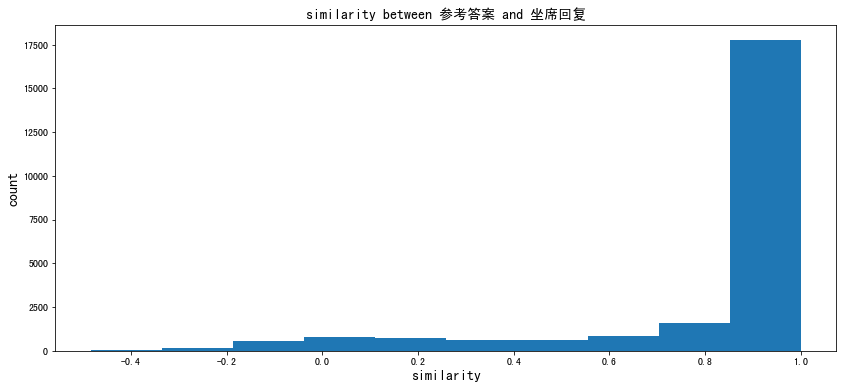

In [569]:
plt.figure(figsize=(14,6))
plt.title('similarity between 参考答案 and 坐席回复', fontsize=14 )
ha_answer_99['score'].plot(kind='hist')
plt.xlabel('similarity', fontsize=14 )
plt.ylabel('count', fontsize=14 )
plt.show()

In [547]:
display(ha_answer_99[(ha_answer_99['score']>0.8) & (ha_answer_99['diff']>10)][['用户问题', '参考答案', '坐席回复', 'score']].sample(n=100))

,用户问题,参考答案,坐席回复,score
2872,谢谢,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,不客气，亲爱哒，很高兴为您服务。,0.981664
1115,你们有原装耳机吗,电脑端：点击链接选择手机以及配件https://shouji.suning.com/。手机端：点击链接选择手机以及配件https://c.m.suning.com/03homePage.html。,手机端：点击链接选择手机以及配件https://c.m.suning.com/03homePage.html。,0.993216
18809,谢谢,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,不客气，应该的哈,0.833652
13791,麻烦，发邮政不行吗,如果商品在页面显示“由苏宁销售和发货的”，是由我司苏宁快递给您配送的（无法指定发其它快递），厂家配送和商家商品用的是第三方快递，如：韵达、圆通、申通、中通、顺丰、EMS等,如果商品在页面显示“由苏宁销售和发货的”，是由我司苏宁快递给您配送的（无法指定发其它快递）,0.887623
18272,我想买个iPad，然后选到门店支付,亲爱哒，您在下单的时候支付方式选择门店支付，提交订单后24小时内去任意门店支付就可以的哦。门店支付可以使用现金，刷卡，礼品卡付款。温馨提示门店支付，不支持优惠券或者云钻等抵扣哦~,您在下单的时候支付方式选择门店支付，提交订单后24小时内去任意门店支付就可以的,0.897500
8115,好的,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,不客气，亲爱哒，很高兴为您服务。还有什么可以帮您？[握手],0.892550
8221,退货的云钻什么时候返还啊,订单退货完成后，云钻和未过期的优惠券将会在24小时内返还到账户；免息券不退哦 （温馨提示：已发出的运费券无法退还，并且券过期了也是不会退回的，商家订单取消时需要选择退货退款，否则不予退还哦）,订单退货完成后，云钻和未过期的优惠券将会在24小时内返还到账户；）,0.805869
15795,好的，谢谢。,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,不客气，亲爱哒，很高兴为您服务,0.981664
22934,好的谢谢了,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持。,0.993809
4961,退货的时候忘记弄发票,您好，给下订单信息，苏苏帮您核实一下，（温馨提示：若您当时开具了纸质发票，退货时需将发票一起寄回，电子发票无需寄回）,亲亲若您当时开具了纸质发票，退货时需将发票一起寄回，电子发票无需寄回的,0.854291


In [558]:
ha_answer_99.loc[[1,152,177,23709,23770,3,21],['用户问题', '参考答案', '坐席回复', 'score']]

,用户问题,参考答案,坐席回复,score
1,那要是裸机是不是不保,裸机是指没有绑定任何合约购买的手机，不是只有手机的哈，自带充电器也是有的，具体以包装清单为准的哦,俯首是春，仰首是秋，每一次的期待都盼望与您相遇！感谢您的咨询，还有什么需要小苏帮助您的呢[鲜花],0.240055
152,易付宝怎么激活,电脑端自助修改：登录账户（非信任登录），点击立即使用认证，如果该实名认证信息非本人，点击页面“申请变更”，根据页面提示上传资料（身份证正反面，手持身份证照片），等待1个工作日内审核。,您需要下载苏宁金融亲,0.114642
177,安装费还有架子怎么收费的,您好，新机安装过程中，包装箱以外增加的材料、配件等是另计收费的！安装前工人会先为您做价格预算，收费时会出示价目表，请您放心！具体安装价格公示优先查看该商品的详情页，另外对于路程较远的地址可能会...,亲，麻烦提供一下您的订单号或者手机号我们这边帮您查询一下,0.300803
23709,包安装吗？,大家电提供安装服务，可在商品购买页查看安装服务方，如显示苏宁安装，配送完成后，会有当地网点跟您预约安装时间；如果显示供应商提供安装服务，需自行联系厂家进行预约安装，（商品页面--售后保障-售后...,是我们苏宁安装的呢,0.433300
23770,安装是需要购买什么东西吗,您好，苏宁安装新机大部分品类安装免人工费，工程师服务前向用户出示收费价目表/明细，若涉及原配件之外的材料是按照收费标准，具体可参考商品详情页安装收费标准或$url=http://help.su...,三角阀、软管、接头等,0.024332
3,有质保吗,您好， 因商品生产批次较多，因商品生产批次较多，暂无法确定您购买商品的生产日期，不过请您放心，苏宁所卖商品均按照国家要求的保质期管理规范进行操作的。,亲 有的,-0.023777
21,我在苏宁总部，明天可以送到吗？,【苏宁发货】商品，页面会显示预计到达时间（以提交订单时显示的时间为准）下单后按照您指定的日期配送。非苏宁发货商品下单后在48小时内发货，以快递信息为准。http://order.suning....,可以的亲,-0.018216


In [548]:
display(ha_answer_99[ha_answer_99['score']<0.8][['用户问题', '参考答案', '坐席回复', 'score']])

,用户问题,参考答案,坐席回复,score
0,物流太差了，跟京东没得比,非常抱歉给您添麻烦了。亲和苏苏说一下情况，苏苏这边帮您处理。,亲 请问还有其他可以为您服务的吗,0.526001
1,那要是裸机是不是不保,裸机是指没有绑定任何合约购买的手机，不是只有手机的哈，自带充电器也是有的，具体以包装清单为准的哦,俯首是春，仰首是秋，每一次的期待都盼望与您相遇！感谢您的咨询，还有什么需要小苏帮助您的呢[鲜花],0.240055
3,有质保吗,您好， 因商品生产批次较多，因商品生产批次较多，暂无法确定您购买商品的生产日期，不过请您放心，苏宁所卖商品均按照国家要求的保质期管理规范进行操作的。,亲 有的,-0.023777
4,货到付款的订单能不能修改成在线支付？,下单的时候保存详细的收货地址，在支付方式里面会显示是否支持货到付款的，如果不支持的话会提示您使用在线支付。选择货到付款的支付方式，您可以选择现金支付或者移动POS刷卡支付。点击链接http:/...,欠款-物流收 李小姐 15915717838 广州市南沙区全区南沙街珠电路中央郡5栋1003房,0.111694
9,大晚上联系我干啥？,很抱歉，让您久等了。请选择以下售后问题咨询,很抱歉，让您久等了,0.630947
16,好了，谢谢,不客气，亲爱的，应该的哈！,麻烦您了，不客气，亲爱的，应该的哈！还有什么可以帮您？,0.789829
18,好吧,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,亲，对给您带来的困扰表示抱歉,0.741523
19,那什么时候能有货呢,您这边在下单的时候选择您的城市地址，能够成功下单支付的都是有现货的哦,亲 这个小苏也不知道呢,0.242070
20,我还是抢不到,网站不提供价格、库存保护，因工厂调价、促销结束、抢购等造成的价格、库存变化以付款时为准。给您造成不便，敬请谅解！,稍等的哈,0.274749
21,我在苏宁总部，明天可以送到吗？,【苏宁发货】商品，页面会显示预计到达时间（以提交订单时显示的时间为准）下单后按照您指定的日期配送。非苏宁发货商品下单后在48小时内发货，以快递信息为准。http://order.suning....,可以的亲,-0.018216


问题基本上同tf-idf, 但效果比tf-idf更好    
在这个数据下, word embedding avg 效果感觉还不错. 能够正确分辨两个句子的主题是否相近, 但现在的数据库相对而言是很干净的, 并没有太多人工输入, 不需要担心同义词和其他可能问题. 另外, 仍然是靠关键字抓主题, 对于细微的语意无法准确分辨   
对的句子能够拿到高分, 但细微错误的句子也可以拿到高分, 完全错的则是低分   

## quick-thought

参考答案长度太长, 对于模型的训练更加困难, 应检视现有客服人工答案的长度分布  
可以使用客服手动回答的聊天本文, 让model学会一般问答的配对

In [586]:
ha_answer_99.loc[[13791, 8221, 4961, 19808, 22725, 9430, 16980],['用户问题', '参考答案', '坐席回复', 'score']]

,用户问题,参考答案,坐席回复,score
13791,麻烦，发邮政不行吗,如果商品在页面显示“由苏宁销售和发货的”，是由我司苏宁快递给您配送的（无法指定发其它快递），厂家配送和商家商品用的是第三方快递，如：韵达、圆通、申通、中通、顺丰、EMS等,如果商品在页面显示“由苏宁销售和发货的”，是由我司苏宁快递给您配送的（无法指定发其它快递）,0.887623
8221,退货的云钻什么时候返还啊,订单退货完成后，云钻和未过期的优惠券将会在24小时内返还到账户；免息券不退哦 （温馨提示：已发出的运费券无法退还，并且券过期了也是不会退回的，商家订单取消时需要选择退货退款，否则不予退还哦）,订单退货完成后，云钻和未过期的优惠券将会在24小时内返还到账户；）,0.805869
4961,退货的时候忘记弄发票,您好，给下订单信息，苏苏帮您核实一下，（温馨提示：若您当时开具了纸质发票，退货时需将发票一起寄回，电子发票无需寄回）,亲亲若您当时开具了纸质发票，退货时需将发票一起寄回，电子发票无需寄回的,0.854291
19808,发什么快递,如果商品在页面显示“由苏宁销售和发货的”，是由我司苏宁快递给您配送的（无法指定发其它快递），厂家配送和商家商品用的是第三方快递，如：韵达、圆通、申通、中通、顺丰、EMS等,如果商品在页面显示“由苏宁销售和发货的”，是由我司苏宁快递给您配送的（无法指定发其它快递）,0.887623
22725,什么是苏宁支付？,苏宁支付方式目前有任性付、门店支付、易付宝支付、网银支付、快捷支付、分期付款、支付宝支付、微信支付、企业汇款、货到付款、和扫码支付，找人代付。您可以点击链接http://help.suning...,苏宁支付方式目前有任性付、易付宝支付、网银支付等,0.879004
9430,还有怎么退费如果拒收,您好，由苏宁快递配送的商品您在拒收以后自动为您办理退款（如已到了末站配送状态可和物流记录上的师傅拒收下呢）。退单后退款回您的原支付账户。第三方快递配送的商品请及时与页面客服客服联系办理退款。,亲，由苏宁快递配送的商品您在拒收以后自动为您办理退款。退单后退款回您的原支付账户。,0.864797
16980,谢谢,不客气，亲爱哒，很高兴为您服务。感谢您对苏宁易购的支持，如果您对我的服务满意记得给我个赞哈。,不客气,0.852193


1. 參考答案特別長, 回覆非常詳細, 包含許多用戶並沒有問的問題, 客服回答通常較精簡    
2. 參考答案一共1000多句, 手邊並沒有參考答案相似的句型, 無法訓練機器人. 在還沒有數據的情況下, 只能以關鍵字匹配為主      
3. 希望能夠提供優秀客服的問答紀錄. 並以優秀克服的問答來訓練評分模型     
